# Pre-processing and exploration of data


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
dow = pd.read_csv('/content/drive/My Drive/Tesis Konstanz/Clean data/data/djia_cleaned_quote.csv')
dow['NUM_TICKS'] = 1
#dow['VOLAT'] = dow.MID_QUOTE #in the resample I take the std of this
s_p = pd.read_csv('/content/drive/My Drive/Tesis Konstanz/Clean data/data/s&p_cleaned_quote1.csv')
s_p['NUM_TICKS'] = 1
#s_p['VOLAT'] = dow.MID_QUOTE
apple = pd.read_csv('/content/drive/My Drive/Tesis Konstanz/Clean data/data/apple_cleaned_quote.csv')
apple['NUM_TICKS'] = 1
#apple['VOLAT'] = dow.MID_QUOTE


In [4]:
def resample_quote(clean_data,interval='s'): 
  clean_data = clean_data.set_index(pd.DatetimeIndex(clean_data['TIME_M']))
  clean_data= clean_data.resample(interval).agg({'BID':'mean', 'ASK':'mean',
                                                 'ASKSIZ':'sum','BIDSIZ':'sum',
                                                 'SPREAD':'mean','MID_QUOTE':'mean',
                                                 'NUM_TICKS':'sum' }) #,'VOLAT':'sum' But some seconds only have 1 obs
                                                
  clean_data = clean_data.dropna()
  UPDATE_BID = clean_data['BID'] - clean_data['BID'].shift(1)
  UPDATE_ASK = clean_data['ASK'] - clean_data['ASK'].shift(1)
  return clean_data[(UPDATE_BID!=0)&(UPDATE_ASK!=0)].copy() #we consider only prices that changed the next period for the t-stat

In [5]:
#Resamplig data 
dow_sec = resample_quote(dow)
window_stop_row = dow_sec[dow_sec.index < '2018-02-05 09:55:01'].iloc[-1]
print('The index at 9:55 am is', dow_sec.index.get_loc(window_stop_row.name))
s_p_sec = resample_quote(s_p)
window_stop_row = s_p_sec[s_p_sec.index < '2010-05-06 09:55:01'].iloc[-1]
print('The index at 9:55 am is',s_p_sec.index.get_loc(window_stop_row.name))
apple_sec = resample_quote(apple)
window_stop_row = apple_sec[apple_sec.index < '2010-05-06 09:55:01'].iloc[-1]
print('The index at 9:55 am is',apple_sec.index.get_loc(window_stop_row.name))

The index at 9:55 am is 1500
The index at 9:55 am is 1474
The index at 9:55 am is 1479


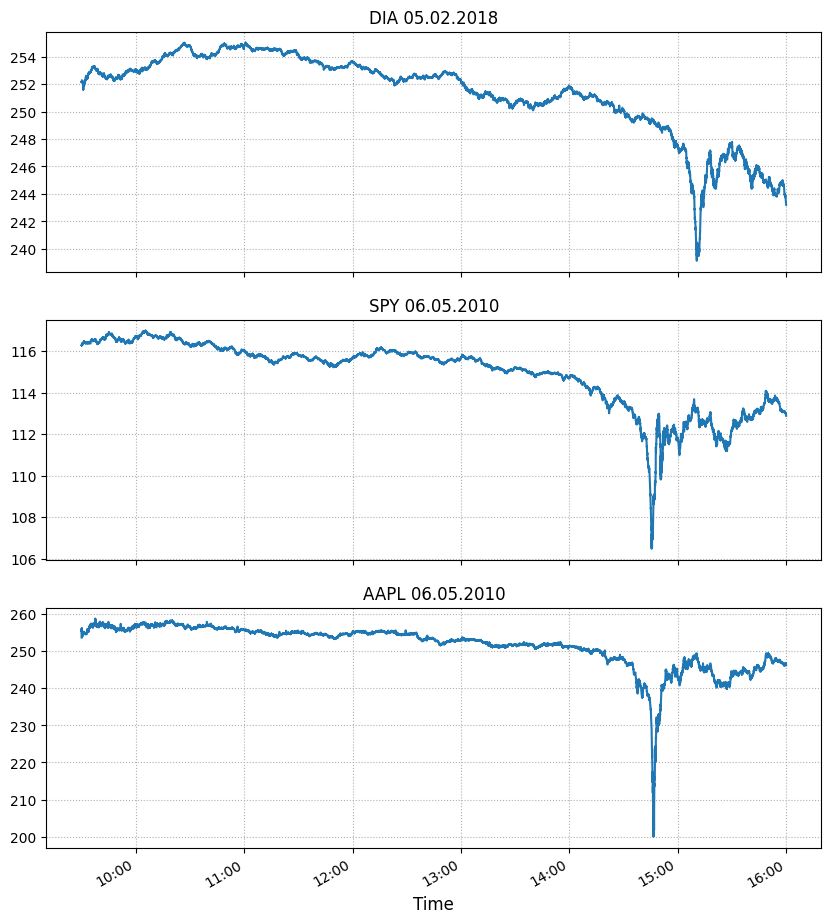

In [ ]:
#Exploratory graphs
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

fig, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax0 = dow_sec['MID_QUOTE'].plot(ax=axarr[0])
ax0.set_title('DIA 05.02.2018')
plt.setp(ax0.get_xticklabels(), visible=False) #Time line invisible
ax0.xaxis.label.set_visible(False)#Variable name "TIME_M" invisible
ax0.yaxis.set_major_locator(MaxNLocator(integer=True)) #This subplot showed float y axis, we had to set it int
ax0.grid(linestyle='dotted')

ax1 = s_p_sec['MID_QUOTE'].plot(ax=axarr[1])
ax1.set_title('SPY 06.05.2010')
plt.setp(ax1.get_xticklabels(), visible=False) 
ax1.xaxis.label.set_visible(False)
ax1.grid(linestyle='dotted')


ax2 = apple_sec['MID_QUOTE'].plot(ax=axarr[2])
ax2.xaxis.set_major_locator(mdates.AutoDateLocator()) #Automatically identify it as dayly
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #X axis display this format
ax2.set_title('AAPL 06.05.2010')
ax2.grid(linestyle='dotted')

plt.xlabel("Time", fontsize=12)
plt.show()


# .axes.get_xaxis().set_visible(False) 

In [ ]:
# Statistics of the series
print('Descriptive stats DIA')
#Formatting the table:
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
dow_sec.describe()

Descriptive stats DIA


,BID,ASK,ASKSIZ,BIDSIZ,SPREAD,MID_QUOTE,NUM_TICKS
count,23380,23380,23380,23380,23380,23380,23380
mean,251.27,251.34,685.87,730.32,0.07,251.30,147.20
std,3.04,3.01,601.99,688.98,0.06,3.02,122.69
min,239.03,239.23,1,1,0.01,239.13,1
25%,250.28,250.34,274,265,0.05,250.31,63
50%,252.35,252.41,520,524,0.06,252.38,115.50
75%,253.45,253.49,911.25,972.25,0.07,253.47,195
max,255.00,255.05,6394,8352,1.00,255.02,1471


In [ ]:
print('Descriptive stats SPY')
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
s_p_sec.describe()

Descriptive stats SPY


,BID,ASK,ASKSIZ,BIDSIZ,SPREAD,MID_QUOTE,NUM_TICKS
count,22827,22827,22827,22827,22827,22827,22827
mean,114.88,114.89,"22,898.56","22,706.69",0.02,114.89,155.06
std,1.64,1.62,"33,074.05","37,249.10",0.03,1.63,110.45
min,106.34,106.60,1,1,0.01,106.47,1
25%,113.70,113.71,"4,708.50",4453,0.01,113.71,67
50%,115.53,115.54,11929,10928,0.01,115.54,129
75%,115.96,115.98,28861,27878,0.02,115.97,220
max,116.99,117.00,640916,896223,0.48,117.00,803


In [ ]:
print('Descriptive stats AAPL')
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
apple_sec.describe()

Descriptive stats AAPL


,BID,ASK,ASKSIZ,BIDSIZ,SPREAD,MID_QUOTE,NUM_TICKS
count,22492,22492,22492,22492,22492,22492,22492
mean,251.21,251.68,200.18,226.59,0.47,251.44,22.93
std,5.98,5.80,529.01,933.73,0.50,5.89,21.68
min,198.96,201.00,1,1,0.02,199.98,1
25%,248.11,248.45,29,29,0.19,248.27,8
50%,253.03,253.33,79,79,0.34,253.16,16
75%,255.14,255.51,199,200,0.57,255.31,31
max,258.06,260.12,41898,53845,7.31,258.81,197


# Drift Burst and Isolation Forest

## Drift Bursts

In [8]:
# We need all the t-stats estimated as drift burst. 

#Apple 06.05.2010
pkl_file = open('/content/drive/My Drive/Tesis Konstanz/Clean data/t_test_apple_06_05_10.pkl', 'rb')
T_apple = pickle.load(pkl_file)
pkl_file.close()

#S&P 500 (SPY) 06.05.2010
pkl_file = open('/content/drive/My Drive/Tesis Konstanz/Clean data/t_test_sp_06_05_10.pkl', 'rb')
T_sp1 = pickle.load(pkl_file)
pkl_file.close()

#DJIA (DIA) 05.02.2018
pkl_file = open('/content/drive/My Drive/Tesis Konstanz/Clean data/t_test_dj_05_02_18.pkl', 'rb')
T_dj = pickle.load(pkl_file)
pkl_file.close()


#S&P 500 will be my training set, while DJIA will be my test set (Ommiting first 25 minutes)
X_train = pd.DataFrame(abs(T_sp1[1474:]))
X_test = pd.DataFrame(abs(T_dj[1500:]))  

[-4.75260927 -0.32591429  3.49550233]
[-4.64840153 -0.378528    2.95598713]
[-4.66328004 -0.1692561   2.82410408]


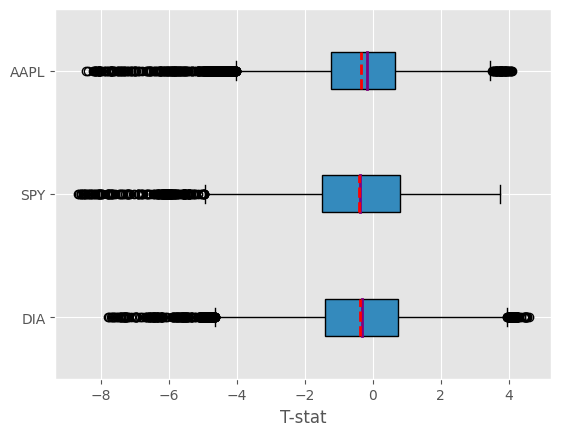

In [ ]:
#Optimal threshold by percentile and Box-Plot
print(np.percentile(T_dj[1500:], [1, 50, 99]))
#lowest 1% -4.72, highest 99% 3.68 for Dow Jones (DIA)
print(np.percentile(T_sp1[1474:], [1, 50, 99]))
#lowest 1% -4.52, highest 99% 3.22 for S&P 500 (SPY)
print(np.percentile(T_apple[1479:], [1, 50, 99]))
#lowest 1% -4.58, highest 99% 2.9 for Dow Jones

plt.style.use('ggplot')

fig, ax = plt.subplots()
ax.boxplot((T_dj[1500:], T_sp1[1474:], T_apple[1479:]), labels= ['DIA', 'SPY', 'AAPL'], vert=False, showmeans=True, meanline=True,
           patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
plt.xlabel("T-stat", fontsize=12)
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.2.png')
plt.show()

## Isolation forest

In [9]:
#Isolation forest algorithm 
alg=IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, \
                    max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
#Default Iforest with 100 trees and max 256 samples. 
#For replication purposes I set a seed at the integer 42 

In [10]:
#Isolation forest training
if_mdlLst=alg.fit(X_train)
#iForest prediction
if_y_pred=if_mdlLst.predict(X_test)

#classified as -1 are anomalous  
print('The number of drift bursts in dow-jones are', sum(if_y_pred==-1))

#Threshold
thres = abs(X_test[if_y_pred==-1]) 
thres = thres.min()
print ('The initial threshold is', thres[0])



The number of drift bursts in dow-jones are 252
The initial threshold is 4.6526030309034905


# Flash and Mini-Flash Crashes

In [ ]:
#Drift burst DJIA (DIA)

db_dow = dow_sec[1500:-2][abs(T_dj[1500:])>=thres[0]]
db_dow['DRIFT_BURST'] = T_dj[1500:][abs(T_dj[1500:])>=thres[0]]
db_des_dow = db_dow.describe()
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
db_des_dow.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.1.tex')
db_des_dow

,BID,ASK,ASKSIZ,BIDSIZ,SPREAD,MID_QUOTE,NUM_TICKS,DRIFT_BURST
count,252,252,252,252,252,252,252,252
mean,243.16,243.36,"1,797.84","2,435.88",0.20,243.26,447.19,-5.63
std,4.18,4.11,"1,162.15","1,504.28",0.10,4.14,235.94,0.91
min,239.03,239.23,279,177,0.03,239.13,63,-7.79
25%,240.00,240.29,981.50,1391,0.12,240.15,284,-6.35
50%,242.09,242.38,"1,520.50",2206,0.19,242.25,400.50,-5.33
75%,244.29,244.42,"2,298.25","3,164.50",0.26,244.36,577.25,-4.87
max,254.20,254.25,6394,7284,0.57,254.22,1321,-4.65


In [ ]:
#Drift burst S&P 500 (SPY)
db_sp = s_p_sec[1474:-2][abs(T_sp1[1474:])>=thres[0]]
db_sp['DRIFT_BURST'] = T_sp1[1474:][abs(T_sp1[1474:])>=thres[0]]
db_des_sp = db_sp.describe()
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
db_des_sp.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.2.tex')
db_des_sp

,BID,ASK,ASKSIZ,BIDSIZ,SPREAD,MID_QUOTE,NUM_TICKS,DRIFT_BURST
count,214,214,214,214,214,214,214,214
mean,109.30,109.38,"30,517.36","22,586.37",0.08,109.34,371.06,-6.35
std,1.82,1.75,"30,884.42","19,747.29",0.10,1.79,125.08,1.10
min,106.34,106.60,99,80,0.01,106.47,20,-8.68
25%,107.50,107.59,"8,493.75","7,582.50",0.02,107.54,315,-7.20
50%,109.84,109.87,23531,18576,0.03,109.86,398,-6.08
75%,110.47,110.51,"43,366.25","33,493.75",0.11,110.49,455.75,-5.55
max,113.34,113.36,237996,106917,0.43,113.35,573,-4.65


In [ ]:
#Drift burst Apple (APPL)
db_apple = apple_sec[1479:-2][abs(T_apple[1479:])>=thres[0]]
db_apple['DRIFT_BURST'] = T_apple[1479:][abs(T_apple[1479:])>=thres[0]]
db_des_apple = db_apple.describe()
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
db_des_apple.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.3.tex')
db_des_apple


,BID,ASK,ASKSIZ,BIDSIZ,SPREAD,MID_QUOTE,NUM_TICKS,DRIFT_BURST
count,213,213,213,213,213,213,213,213
mean,230.56,232.34,"1,142.03","1,760.76",1.78,231.45,75.66,-6.10
std,17.78,16.08,"3,534.18","4,248.24",1.90,16.92,43.09,1.15
min,198.96,201.00,11,13,0.09,199.98,6,-8.43
25%,214.77,217.15,237,314,0.30,215.98,40,-7.11
50%,239.05,239.45,482,656,0.56,239.25,68,-5.88
75%,246.56,246.82,1032,1269,3.24,246.70,111,-4.99
max,253.01,253.10,41898,38947,6.95,253.05,197,-4.66


## Endogenous Identification of Flash Crash from drift bursts

In [ ]:
#Flas crash counter
def fc_counter(T_stat):
  """Endogenous counter of Flash Crashes based on negative drift burst"""
  start=[]
  end=[]
  j=0
  i=1
  for i in range(1,len(T_stat)):
    
    if (T_stat[j] > T_stat[i]) & (i == len(T_stat)-1):
      end.append(i)
      start.append(j)
      
    elif T_stat[j]<=T_stat[i]:
      end.append(i-1)
      start.append(j)
      j=i
    
  return start,end

In [ ]:
def fc_counter(T_stat, threshold):
  """Endogenous counter of Flash Crashes based on negative drift burst"""
  start=[]
  end=[]
  for i in range(1,len(T_stat)):
    if (T_stat[i] <= -threshold) & (T_stat[i-1]>-threshold):
      start.append(i-1)
    
    if (T_stat[i]>-threshold) & (T_stat[i-1]<=-threshold):
      end.append(i)
  return start, end


In [ ]:
fc_start_dj = dow_sec[1500:-2].iloc[fc_counter(T_dj[1500:],thres[0])[0]] 
fc_end_dj = dow_sec[1500:-2].iloc[fc_counter(T_dj[1500:],thres[0])[1]]

fc_start_sp = s_p_sec[1474:-2].iloc[fc_counter(T_sp1[1474:],thres[0])[0]]
fc_end_sp = s_p_sec[1474:-2].iloc[fc_counter(T_sp1[1474:],thres[0])[1]]

fc_start_apple = apple_sec[1479:-2].iloc[fc_counter(T_apple[1479:],thres[0])[0]]
fc_end_apple = apple_sec[1479:-2].iloc[fc_counter(T_apple[1479:],thres[0])[1]]

In [ ]:
def loss_peak(fc_start, fc_end, orig):
  i=0
  loss_peak = []
  while i < len(fc_start):
    log_min = np.log(np.min(orig.MID_QUOTE.loc[fc_start.index[i]:fc_end.index[i]]))
    log_start = np.log(fc_start.MID_QUOTE.iloc[i])
    loss_peak.append((log_min - log_start)*100)
    i+=1

  return loss_peak




## Flash Crash Stats

In [ ]:
#S&P 500 SPY Flash Crash Stats

fc_stats_sp = fc_start_sp[['MID_QUOTE','NUM_TICKS']].copy()
fc_stats_sp['END_TIME'] = fc_end_sp.index
fc_stats_sp['DURATION'] = fc_end_sp.index - fc_start_sp.index
fc_stats_sp['LOSS_PEAK'] = loss_peak(fc_start_sp,fc_end_sp, s_p_sec)
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
fc_stats_sp.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.4.tex')
fc_stats_sp

,MID_QUOTE,NUM_TICKS,END_TIME,DURATION,LOSS_PEAK
TIME_M,,,,,
2010-05-06 14:20:57,113.37,485,2010-05-06 14:21:08,00:00:11,-0.11
2010-05-06 14:21:58,113.11,270,2010-05-06 14:22:02,00:00:04,-0.09
2010-05-06 14:40:14,111.82,434,2010-05-06 14:40:16,00:00:02,-0.15
2010-05-06 14:42:59,111.19,381,2010-05-06 14:43:08,00:00:09,-0.18
2010-05-06 14:43:08,111.07,454,2010-05-06 14:46:21,00:03:13,-4.23


In [ ]:
#Dow Jones DIA Flash Crash Stats

fc_stats_dj = fc_start_dj[['MID_QUOTE','NUM_TICKS']].copy()
fc_stats_dj['END_TIME'] = fc_end_dj.index
fc_stats_dj['DURATION'] = fc_end_dj.index - fc_start_dj.index
fc_stats_dj['LOSS_PEAK'] = loss_peak(fc_start_dj,fc_end_dj, dow_sec)
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
fc_stats_dj.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.5.tex')
fc_stats_dj

,MID_QUOTE,NUM_TICKS,END_TIME,DURATION,LOSS_PEAK
TIME_M,,,,,
2018-02-05 10:31:51,254.22,58,2018-02-05 10:32:18,00:00:27,-0.06
2018-02-05 15:06:57,245.11,351,2018-02-05 15:07:06,00:00:09,-0.10
2018-02-05 15:07:06,244.87,745,2018-02-05 15:07:11,00:00:05,-0.00
2018-02-05 15:07:12,244.94,473,2018-02-05 15:07:42,00:00:30,-0.36
2018-02-05 15:08:13,244.47,213,2018-02-05 15:08:21,00:00:08,-0.06
2018-02-05 15:08:22,244.33,120,2018-02-05 15:08:35,00:00:13,-0.09
2018-02-05 15:08:37,244.22,373,2018-02-05 15:08:43,00:00:06,-0.11
2018-02-05 15:08:43,243.96,1107,2018-02-05 15:08:46,00:00:03,0
2018-02-05 15:08:55,244.13,186,2018-02-05 15:08:58,00:00:03,-0.05


In [ ]:
print(db_dow.loc['2018-02-05 15:08:43':'2018-02-05 15:08:47'])
print(dow_sec.loc['2018-02-05 15:08:43':'2018-02-05 15:08:47'])

                       BID    ASK  ASKSIZ  ...  MID_QUOTE  NUM_TICKS  DRIFT_BURST
TIME_M                                     ...                                   
2018-02-05 15:08:44 244.03 244.26    2267  ...     244.14        450        -4.72
2018-02-05 15:08:45 244.00 244.17    1347  ...     244.09        280        -4.74

[2 rows x 8 columns]
                       BID    ASK  ASKSIZ  BIDSIZ  SPREAD  MID_QUOTE  NUM_TICKS
TIME_M                                                                         
2018-02-05 15:08:43 243.88 244.05    5067    6116    0.18     243.96       1107
2018-02-05 15:08:44 244.03 244.26    2267    2285    0.23     244.14        450
2018-02-05 15:08:45 244.00 244.17    1347    1400    0.17     244.09        280
2018-02-05 15:08:46 243.95 244.12    1476    1312    0.16     244.04        265
2018-02-05 15:08:47 244.00 244.11     638     823    0.11     244.05        189


In [ ]:
#Apple AAPL Flash Crash Stats

fc_stats_ap = fc_start_apple[['MID_QUOTE','NUM_TICKS']].copy()
fc_stats_ap['END_TIME'] = fc_end_apple.index
fc_stats_ap['DURATION'] = fc_end_apple.index - fc_start_apple.index
fc_stats_ap['LOSS_PEAK'] = loss_peak(fc_start_apple,fc_end_apple, apple_sec)
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
fc_stats_ap.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.6.tex')
fc_stats_ap

,MID_QUOTE,NUM_TICKS,END_TIME,DURATION,LOSS_PEAK
TIME_M,,,,,
2010-05-06 12:38:09,253.14,47,2010-05-06 12:38:41,00:00:32,-0.18
2010-05-06 14:20:43,247.77,11,2010-05-06 14:21:12,00:00:29,-0.54
2010-05-06 14:36:56,242.57,115,2010-05-06 14:37:55,00:00:59,-1.66
2010-05-06 14:40:07,238.00,58,2010-05-06 14:40:09,00:00:02,-0.16
2010-05-06 14:45:23,230.29,126,2010-05-06 14:46:59,00:01:36,-14.11


In [ ]:
fig, axarr = plt.subplots(3, 1, figsize=(12, 15))

################################################################################
#DIA Graph and Stats
################################################################################

dj_graph = dow_sec[['MID_QUOTE']][1474:-2].copy()
dj_graph['T_Stat'] = T_dj[1474:]
dj_graph = dj_graph.loc['2018-02-05 14:00:00':'2018-02-05 16:00:00']

#plt.figure(figsize=(12,5))

ax1 = dj_graph.MID_QUOTE.plot(color='blue', grid=False, label='Mid Quote',ax=axarr[0])
ax1.xaxis.set_major_locator(mdates.AutoDateLocator()) #Automatically identify it as dayly
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #X axis display this format
ax1.set_ylabel('Mid Quote Price')


ax2 = dj_graph.T_Stat.plot(color='red',secondary_y=True, grid=False, label='Drift Burst t-test',ax=axarr[0])
ax2.fill_between(dj_graph.index, 0, dj_graph.T_Stat,facecolor='red')
ax2.hlines(-4.65, '2018-02-05 14:00:00','2018-02-05 16:00:00', linestyles='dashed')
ax2.annotate('Threshold',('2018-02-05 15:15:00',-5.2)) #https://stackoverflow.com/questions/33149428/modify-the-legend-of-pandas-bar-plot/33150133
ax1.set_xlabel('Time') #plt.xlabel('Time') Does not work
ax2.set_ylabel('Drift Burst t-stat')
ax2.set_title('DIA 05.02.2018')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=3)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2 because ax2 override ax1
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
#plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.4.png')

################################################################################
#SPY Graph and Stats
################################################################################

sp_graph = s_p_sec[['MID_QUOTE']][1500:-2].copy()
sp_graph['T_Stat'] = T_sp1[1500:]
sp_graph = sp_graph.loc['2010-05-06 14:00:00':'2010-05-06 16:00:00']

#plt.figure(figsize=(12,5))

ax1 = sp_graph.MID_QUOTE.plot(color='blue', grid=False, label='Mid Quote',ax=axarr[1])
ax1.xaxis.set_major_locator(mdates.AutoDateLocator()) #Automatically identify it as dayly
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #X axis display this format
ax1.set_ylabel('Mid Quote Price')


ax2 = sp_graph.T_Stat.plot(color='red',secondary_y=True, grid=False, label='Drift Burst t-test',ax=axarr[1])
ax2.fill_between(sp_graph.index, 0, sp_graph.T_Stat,facecolor='red')
ax2.hlines(-4.65, '2010-05-06 14:00:00', '2010-05-06 16:00:00', linestyles='dashed')
ax2.annotate('Threshold',('2010-05-06 15:00:00',-5.2)) #https://stackoverflow.com/questions/33149428/modify-the-legend-of-pandas-bar-plot/33150133
ax1.set_xlabel('Time') #plt.xlabel('Time') Does not work
ax2.set_ylabel('Drift Burst t-stat')
ax2.set_title('SPY 06.05.2010')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=3)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2 because ax2 override ax1
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
#plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.3.png')


################################################################################
#AAPL Graph and Stats
################################################################################

ap_graph = apple_sec[['MID_QUOTE']][1500:-2].copy()
ap_graph['T_Stat'] = T_apple[1500:]
ap_graph = ap_graph.loc['2010-05-06 14:00:00':'2010-05-06 16:00:00']

#plt.figure(figsize=(12,5))

ax1 = ap_graph.MID_QUOTE.plot(color='blue', grid=False, label='Mid Quote',ax=axarr[2])
ax1.xaxis.set_major_locator(mdates.AutoDateLocator()) #Automatically identify it as dayly
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #X axis display this format
ax1.set_ylabel('Mid Quote Price')


ax2 = ap_graph.T_Stat.plot(color='red',secondary_y=True, grid=False, label='Drift Burst t-test',ax=axarr[2])
ax2.fill_between(ap_graph.index, 0, ap_graph.T_Stat,facecolor='red')
ax2.hlines(-4.65, '2010-05-06 14:00:00', '2010-05-06 16:00:00', linestyles='dashed')
ax2.annotate('Threshold',('2010-05-06 15:00:00',-5.2)) #https://stackoverflow.com/questions/33149428/modify-the-legend-of-pandas-bar-plot/33150133
ax1.set_xlabel('Time') #plt.xlabel('Time') Does not work
ax2.set_ylabel('Drift Burst t-stat')
ax2.set_title('AAPL 06.05.2010')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=3)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2 because ax2 override ax1
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.3.png',dpi=300)
plt.show()

In [ ]:
# Reversion 5 minutes log return

def log_returns(price, db, time_change, thres):
  R_pre = np.log(price/price.shift(time_change))*100
  R_pos = np.log(price.shift(-time_change)/price)*100
  R_pos = R_pos[np.abs(db)>=thres[0]]
  R_pre = R_pre[np.abs(db)>=thres[0]]

  return R_pre, R_pos


In [ ]:
#thres = 4.6526030309034905
R_pre_dj, R_pos_dj = log_returns(dow_sec[['MID_QUOTE']][:-2],T_dj,300,thres) 
R_pre_sp, R_pos_sp = log_returns(s_p_sec[['MID_QUOTE']][:-2],T_sp1,300,thres)
R_pre_ap, R_pos_ap = log_returns(apple_sec[['MID_QUOTE']][:-2],T_apple,300,thres)  

In [ ]:
#SP and DJ have obervations before 9:55
R_pre_dj = R_pre_dj.loc['2018-02-05 09:55:00':]
R_pos_dj = R_pos_dj.loc['2018-02-05 09:55:00':]
R_pre_sp = R_pre_sp.loc['2010-05-06 09:55:00':]
R_pos_sp = R_pos_sp.loc['2010-05-06 09:55:00':]


R_pre = pd.concat([R_pre_ap,R_pre_dj,R_pre_sp], axis=0).values
R_pos = pd.concat([R_pos_ap,R_pos_dj,R_pos_sp], axis=0).values
sorted_index = np.argsort(R_pre)
R_pre = R_pre.reshape(-1,1)
R_pos = R_pos.reshape(-1,1)

In [ ]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()
linear_regressor.fit(R_pre,R_pos)
R_pos_pred = linear_regressor.predict(R_pre)
slope = linear_regressor.coef_[0][0]
reversion = 1 - (sum(R_pre>R_pos)/len(R_pre))[0] #Reversion to the previos price 

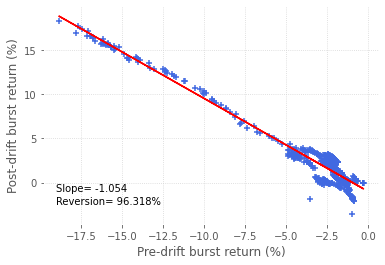

In [ ]:
plt.scatter(R_pre,R_pos, marker='+', color='royalblue')
plt.plot(R_pre,R_pos_pred, color='r')
plt.annotate("Slope= {0:.3f}".format(slope),(-19,-1))
plt.annotate("Reversion= {0:.3f}%".format(reversion*100),(-19,-2.5))
plt.xlabel('Pre-drift burst return (%)')
plt.ylabel('Post-drift burst return (%)')
plt.grid(linestyle='dotted', color='lightgrey')
plt.gca().set_facecolor('white') #To erase the blue background fig.patch.set_facecolor('black') maybe works as well
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.4.png',dpi=300)

## Logit model

In [11]:
#data logit dow jones DIA
dj_logit = dow_sec[['MID_QUOTE','NUM_TICKS','SPREAD']][:-2]
dj_logit['IMB_RATIO'] = np.log10(dow_sec.ASKSIZ/dow_sec.BIDSIZ) #Log10 imbalance ratio
dj_logit['PROB'] = (T_dj<=-thres[0]).astype(int) #1 if dirft burst 0 otherwise dow jones
dj_logit = dj_logit[1500:]

In [12]:
#Intraday (from 9:30) descriptive stats for independent variables DIA
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
dj_logit_stats = dj_logit.describe()
dj_logit_stats.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table_A7.tex')
dj_logit_stats

,MID_QUOTE,NUM_TICKS,SPREAD,IMB_RATIO,PROB
count,21878,21878,21878,21878,21878
mean,251.21,147.09,0.07,-0.01,0.01
std,3.10,123.46,0.06,0.16,0.11
min,239.13,1,0.01,-1.18,0
25%,250.00,62,0.05,-0.10,0
50%,252.18,115,0.06,-0.01,0
75%,253.60,195,0.07,0.08,0
max,255.02,1471,1.00,1.22,1


In [ ]:
#Descriptive imbalance ratio 
print(dj_logit['IMB_RATIO'][T_dj[1500:]<=-thres[0]].describe())

count     252
mean    -0.12
std      0.20
min     -0.84
25%     -0.21
50%     -0.10
75%     -0.00
max      0.49
Name: IMB_RATIO, dtype: float64


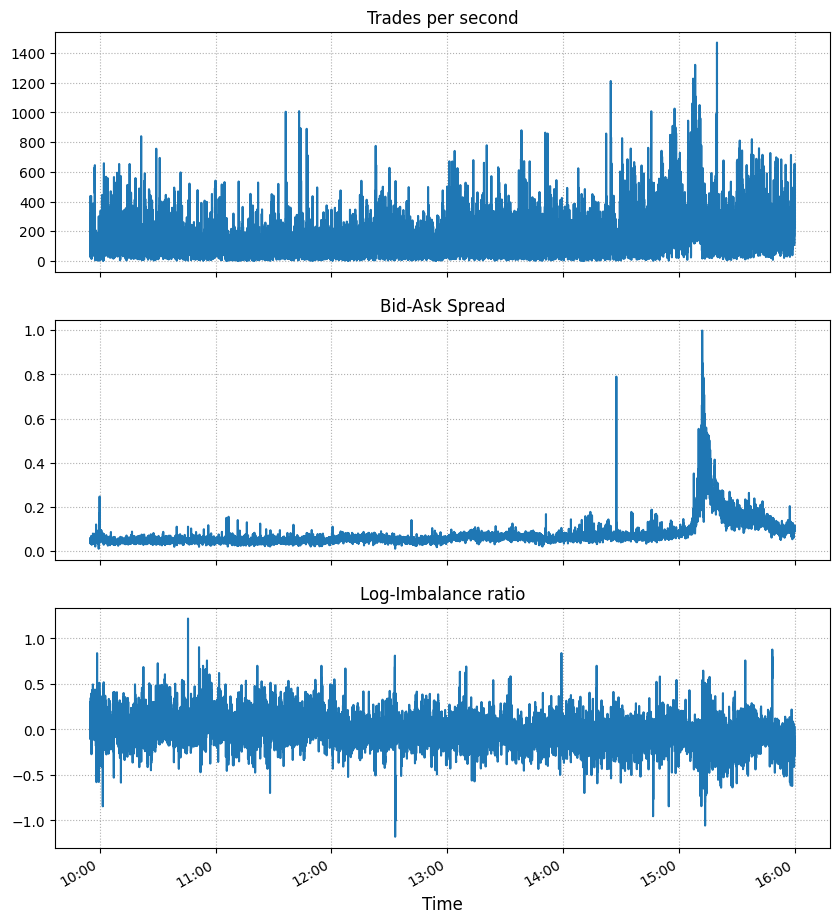

In [ ]:
#Dow Jones (DIA) graph independent variables

fig, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax0 = dj_logit['NUM_TICKS'].plot(ax=axarr[0])
ax0.set_title('Trades per second')
plt.setp(ax0.get_xticklabels(), visible=False) #Time line invisible
ax0.xaxis.label.set_visible(False)#Variable name "TIME_M" invisible
ax0.yaxis.set_major_locator(MaxNLocator(integer=True)) #This subplot showed float y axis, we had to set it int
ax0.grid(linestyle='dotted')

ax1 = dj_logit['SPREAD'].plot(ax=axarr[1])
ax1.set_title('Bid-Ask Spread')
plt.setp(ax1.get_xticklabels(), visible=False) 
ax1.xaxis.label.set_visible(False)
ax1.grid(linestyle='dotted')


ax2 = dj_logit['IMB_RATIO'].plot(ax=axarr[2])
ax2.xaxis.set_major_locator(mdates.AutoDateLocator()) #Automatically identify it as dayly
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #X axis display this format
ax2.set_title('Log-Imbalance ratio')
ax2.grid(linestyle='dotted')

plt.xlabel("Time", fontsize=12)
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.5.png',dpi=300)
plt.show()


In [13]:
#data logit s&p 500 SPY 
sp_logit = s_p_sec[['MID_QUOTE','NUM_TICKS','SPREAD']][:-2]
sp_logit['IMB_RATIO'] = np.log10(s_p_sec.ASKSIZ/s_p_sec.BIDSIZ)
sp_logit['PROB'] = (T_sp1<=-thres[0]).astype(int)
sp_logit = sp_logit[1474:]

In [14]:
#Intraday (from 9:30) descriptive stats for independent variables SPY
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
sp_logit_stats = sp_logit.describe()
sp_logit_stats.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table_A8.tex')
sp_logit_stats

,MID_QUOTE,NUM_TICKS,SPREAD,IMB_RATIO,PROB
count,21351,21351,21351,21351,21351
mean,114.77,154.02,0.02,0.02,0.01
std,1.62,111.56,0.03,0.44,0.10
min,106.47,1,0.01,-2.04,0
25%,113.57,65,0.01,-0.21,0
50%,115.45,127,0.01,0.03,0
75%,115.86,220,0.02,0.27,0
max,117.00,732,0.48,2.20,1


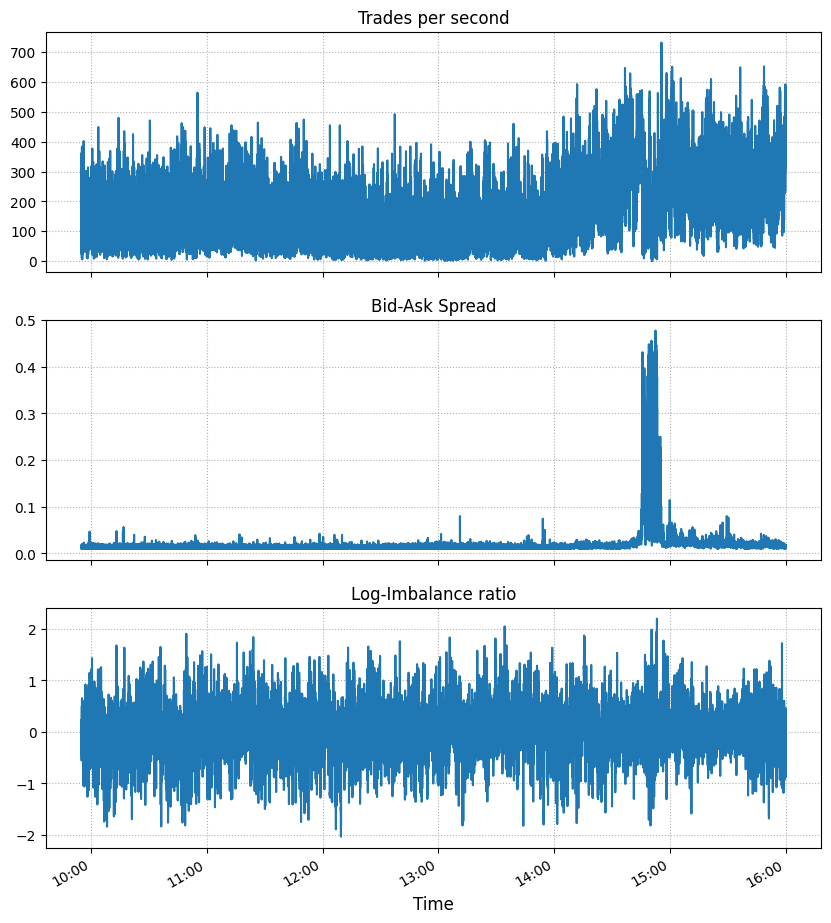

In [ ]:
#S&P 500 (SPY)  graph independent variables

fig, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax0 = sp_logit['NUM_TICKS'].plot(ax=axarr[0])
ax0.set_title('Trades per second')
plt.setp(ax0.get_xticklabels(), visible=False) #Time line invisible
ax0.xaxis.label.set_visible(False)#Variable name "TIME_M" invisible
ax0.yaxis.set_major_locator(MaxNLocator(integer=True)) #This subplot showed float y axis, we had to set it int
ax0.grid(linestyle='dotted')

ax1 = sp_logit['SPREAD'].plot(ax=axarr[1])
ax1.set_title('Bid-Ask Spread')
plt.setp(ax1.get_xticklabels(), visible=False) 
ax1.xaxis.label.set_visible(False)
ax1.grid(linestyle='dotted')


ax2 = sp_logit['IMB_RATIO'].plot(ax=axarr[2])
ax2.xaxis.set_major_locator(mdates.AutoDateLocator()) #Automatically identify it as dayly
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #X axis display this format
ax2.set_title('Log-Imbalance ratio')
ax2.grid(linestyle='dotted')

plt.xlabel("Time", fontsize=12)
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.6.png',dpi=300)
plt.show()

In [ ]:
#descriptive stats imbalance ratio
print(sp_logit['IMB_RATIO'].describe())
print('Max imb. ocurr at', sp_logit['IMB_RATIO'].idxmax())
print('Min imb. ocurr at', sp_logit['IMB_RATIO'].idxmin())

count    21351.000000
mean         0.023948
std          0.438916
min         -2.036574
25%         -0.206998
50%          0.031214
75%          0.270106
max          2.203075
Name: IMB_RATIO, dtype: float64
Max imb. ocurr at 2010-05-06 14:53:11
Min imb. ocurr at 2010-05-06 12:09:29


In [15]:
#data logit apple AAPL
apple_logit = apple_sec[['MID_QUOTE','NUM_TICKS','SPREAD']][:-2]
apple_logit['IMB_RATIO'] = np.log10(apple_sec.ASKSIZ/apple_sec.BIDSIZ)
apple_logit['PROB'] = (T_apple<=-thres[0]).astype(int)
apple_logit = apple_logit[1479:]

In [16]:
#Intraday (from 9:30) descriptive stats for independent variables AAPL
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
apple_logit_stats = apple_logit.describe()
apple_logit_stats.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table_A9.tex')
apple_logit_stats

,MID_QUOTE,NUM_TICKS,SPREAD,IMB_RATIO,PROB
count,21011,21011,21011,21011,21011
mean,251.10,22.97,0.46,-0.01,0.01
std,5.93,21.92,0.49,0.36,0.10
min,199.98,1,0.02,-2.18,0
25%,247.87,8,0.19,-0.20,0
50%,252.80,16,0.33,0,0
75%,255.11,31,0.55,0.19,0
max,258.31,197,7.31,2.23,1


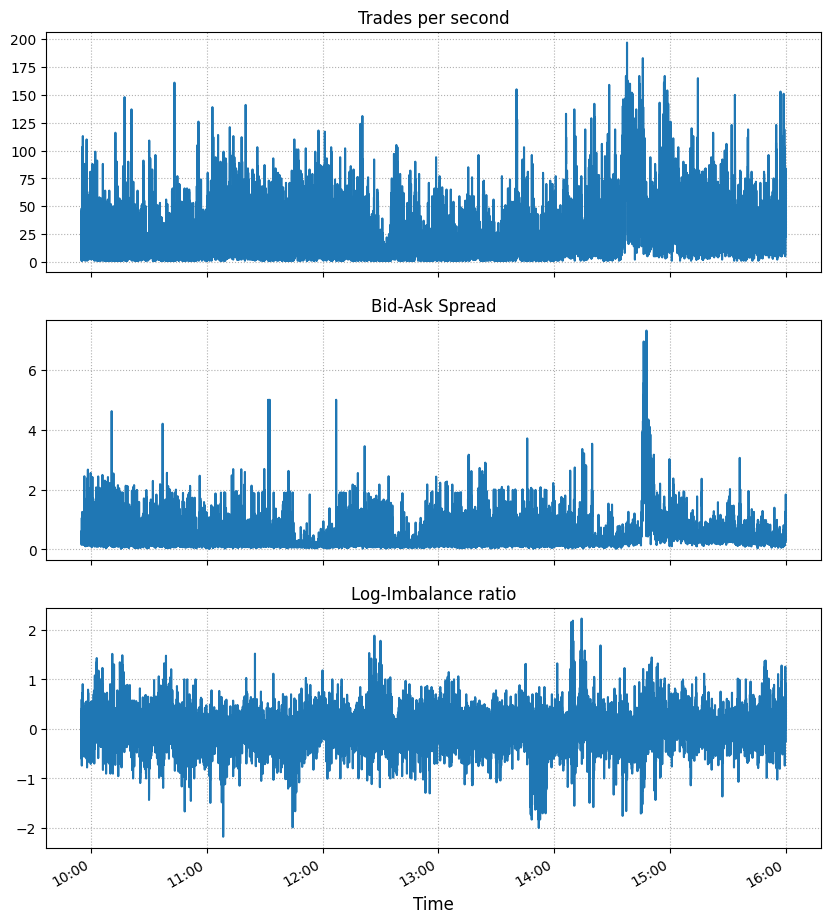

In [21]:
#Apple graph independent variables

fig, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax0 = apple_logit['NUM_TICKS'].plot(ax=axarr[0])
ax0.set_title('Trades per second')
plt.setp(ax0.get_xticklabels(), visible=False) #Time line invisible
ax0.xaxis.label.set_visible(False)#Variable name "TIME_M" invisible
ax0.yaxis.set_major_locator(MaxNLocator(integer=True)) #This subplot showed float y axis, we had to set it int
ax0.grid(linestyle='dotted')

ax1 = apple_logit['SPREAD'].plot(ax=axarr[1])
ax1.set_title('Bid-Ask Spread')
plt.setp(ax1.get_xticklabels(), visible=False) 
ax1.xaxis.label.set_visible(False)
ax1.grid(linestyle='dotted')


ax2 = apple_logit['IMB_RATIO'].plot(ax=axarr[2])
ax2.xaxis.set_major_locator(mdates.AutoDateLocator()) #Automatically identify it as dayly
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #X axis display this format
ax2.set_title('Log-Imbalance ratio')
ax2.grid(linestyle='dotted')

plt.xlabel("Time", fontsize=12)
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig_A1.png',dpi=300)
plt.show()

### Model Selection


In [ ]:
#It's necessary to normalize the data to make it comparable 
#I use the Min-max scaler technique

from sklearn.preprocessing import MinMaxScaler
# build the scaler model
scaler = MinMaxScaler()

Y_train = sp_logit['PROB'] #.loc['2010-05-06 14:00:00':'2010-05-06 15:00:00']
X_train = sp_logit.iloc[:,1:4]
X_train[X_train.columns] = scaler.fit_transform(sp_logit.iloc[:,1:4]) #.loc['2010-05-06 14:00:00':'2010-05-06 15:00:00']
#X_train = sp_logit[['SPREAD','IMB_RATIO']]

Y_test = dj_logit['PROB']
X_test = dj_logit.iloc[:,1:4]
X_test[X_test.columns] = scaler.transform(dj_logit.iloc[:,1:4])

In [ ]:
# After looking at the graphs we compare the 7 models by their AIC

In [ ]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
X_train = sm.add_constant(X_train)
logit_model=sm.Logit(Y_train,X_train[['const','IMB_RATIO']])
result_1=logit_model.fit()

logit_model=sm.Logit(Y_train,X_train[['const','NUM_TICKS']])
result_2=logit_model.fit()

logit_model=sm.Logit(Y_train,X_train[['const','SPREAD' ]])
result_3=logit_model.fit()

logit_model=sm.Logit(Y_train,X_train[['const','NUM_TICKS','SPREAD']])
result_4=logit_model.fit()

logit_model=sm.Logit(Y_train,X_train[['const','IMB_RATIO','NUM_TICKS']])
result_5=logit_model.fit()

logit_model=sm.Logit(Y_train,X_train[['const','IMB_RATIO','SPREAD']])
result_6=logit_model.fit()

logit_model=sm.Logit(Y_train,X_train)
result_7=logit_model.fit()

info={'AIC' : lambda x: "{:.4f}".format(x.aic),
      'BIC' : lambda x: "{:.4f}".format(x.bic),
      'Log-likelihood' : lambda x: "{:.4f}".format(x.llf),
      'Pseudo-R2': lambda x : "{:,.4f}".format(x.prsquared),
      'Log-likelihood ratio': lambda x: "{:,.4f}".format(x.llr),
      'No. observations' : lambda x: "{0:d}".format(int(x.nobs))}
dfoutput = summary_col([result_1,result_2,result_3,result_4,result_5,result_6,result_7],stars=True,info_dict=info)
print(dfoutput)

f = open('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.7.tex', 'w')
f.write(dfoutput.as_latex())
f.close()

#marginal effects 
marginal =  result_7.get_margeff(at='overall')
f = open('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.9.tex', 'w')
f.write(marginal.summary().as_latex())
f.close()

#https://economics.stackexchange.com/questions/11774/outputting-regressions-as-table-in-python-similar-to-outreg-in-stata
#

Optimization terminated successfully.
         Current function value: 0.055926
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042331
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051233
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.041969
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051083
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034446
         Iterations 11

                       PROB I    PROB II    PROB III  PROB IIII  PROB IIIII PROB IIIIII PROB IIIIIII
----------------------------------------------------------------------------------------------------
IMB_RATIO            1.8525***                                   3.5255***  1.6

In [ ]:
#Although AIC is a information criteria, the unbalanced classification might
#play a role, therefore I analize by cross validation

In [ ]:
#matrix of covariates to include
models = dict({'(1)': ['const','IMB_RATIO'],'(2)':['const','NUM_TICKS'],'(3)':['const','SPREAD'],
          '(4)':['const','NUM_TICKS','SPREAD'],'(5)':['const','IMB_RATIO','NUM_TICKS'],
          '(6)':['const','IMB_RATIO','SPREAD'], '(7)': ['const','IMB_RATIO','NUM_TICKS','SPREAD']})


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 
logreg = LogisticRegression(fit_intercept = False, C = 1e9)

#tscv = TimeSeriesSplit(n_splits=2200)
#we can use the defaul splitter but we do not have two categories before observation  number 15413

ix = np.where(Y_train == 1)[0][0] #index where the first drift burst is observed
n = len(Y_train)
cv = []
i = 1
w = 4499
while i < (n - ix - w):
  train = np.arange(i + ix)
  test = np.arange(i + ix ,i + ix + w+1)
  cv.append((train,test))
  i+=1
losses_cv, auc_cv, names, mean_auc, mean_loss = list(), list(), list(), list(), list()
for name, model in models.items():
  score_cv = cross_val_score(logreg, X_train[model], Y_train, cv=cv, scoring='roc_auc')
  loss_cv = cross_val_score(logreg, X_train[model], Y_train, cv=cv, scoring='neg_log_loss')
  names.append(name)
  losses_cv.append(loss_cv)
  auc_cv.append(score_cv)
  mean_auc.append(np.mean(score_cv))
  mean_loss.append(np.mean(loss_cv))


In [ ]:
#Save results as pickle 
output = open('/content/drive/My Drive/Tesis Konstanz/Clean data/losses_cv.pkl', 'wb')
pickle.dump(losses_cv, output)
output.close()

output = open('/content/drive/My Drive/Tesis Konstanz/Clean data/auc_cv.pkl', 'wb')
pickle.dump(auc_cv, output)
output.close()

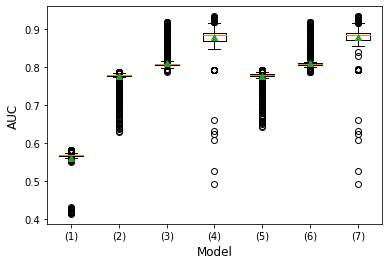

In [ ]:
#Box plot for auc cross validation 
plt.boxplot(auc_cv, labels=names, showmeans=True)
plt.xlabel("Model", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.8.png', dpi=300) #fig4.9 is the illustration of the procedure
plt.show()

In [ ]:
#Descriptive statistics log-losses
log_loss_stats = (-pd.DataFrame(losses_cv)).transpose().describe()
log_loss_stats.columns = ['(1)','(2)','(3)','(4)','(5)','(6)','(7)']
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)
log_loss_stats.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.8.tex')
log_loss_stats

,(1),(2),(3),(4),(5),(6),(7)
count,1438,1438,1438,1438,1438,1438,1438
mean,0.308,0.220,1.342,0.410,0.219,1.341,0.409
std,0.041,0.023,0.349,0.534,0.023,0.348,0.526
min,0.099,0.120,0.765,0.159,0.121,0.758,0.160
25%,0.317,0.220,1.235,0.170,0.219,1.234,0.170
50%,0.318,0.223,1.236,0.181,0.223,1.235,0.181
75%,0.319,0.229,1.238,0.262,0.230,1.237,0.261
max,0.456,0.334,2.941,2.526,0.334,2.940,2.480


In [ ]:
#Feature selection with Recursive Feature Elimination
from sklearn.feature_selection import RFE

rfe = RFE(logreg, 4)
fit = rfe.fit(X_train, Y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


Num Features: 4
Selected Features: [ True  True  True  True]
Feature Ranking: [1 1 1 1]


In [ ]:
#We want to rule out any possibility of multicollinearity, mainly between 
#Imb_ratio and Spread therefore we calculate the variance inflation ratio
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
for i in range(X_train.shape[1])],
index=X_train.columns)


#There is enogh indpendent variation, none of the VIF were above 4

const        24.963801
NUM_TICKS     1.003188
SPREAD        1.003187
IMB_RATIO     1.000001
dtype: float64

### Classification

In [ ]:
#The model with all variables has the lower AIC and BIC, furthermore all are significant
#The model 7 also have the best cross validation results
#I use my testing data with model number 7
X_test = sm.add_constant(X_test)
Y_predict = np.array(result_7.predict(X_test))
Y_predict_in = np.array(result_7.predict(X_train))

In [ ]:
fpr, tpr, thresholds =roc_curve(Y_test, Y_predict )
roc_auc = auc(fpr, tpr)
fpr_in, tpr_in, _ =roc_curve(Y_train, Y_predict_in)
roc_auc_in = auc(fpr_in, tpr_in)
print("Area under the ROC curve, out of sample : %f" % roc_auc)
print("Area under the ROC curve, in-sample : %f" % roc_auc_in)

Area under the ROC curve, out of sample : 0.926285
Area under the ROC curve, in-sample : 0.966848


In [ ]:
def metric_threshold_acc(true_label, pred_proba):
    num_pos_class = sum(true_label)
    num_neg_class = len(true_label) - num_pos_class

    fpr, tpr, thresholds = roc_curve(true_label, pred_proba,pos_label=1)
    #precision, recall, thresholds = precision_recall_curve(true_label, pred_proba)
    tp = tpr * num_pos_class
    tn = (1 - fpr) * num_neg_class
    acc = (tp + tn) /  (num_pos_class + num_neg_class)

    best_threshold = thresholds[np.argmax(acc)]
    tp_r = tpr[np.argmax(acc)]
    
    return np.amax(acc), best_threshold, tp_r
#https://albertusk95.github.io/posts/2019/12/best-threshold-maximize-accuracy-from-roc-pr-curve/

In [ ]:
#Optimal threshold by accuracy criterium
acc, threshold, tp_r = metric_threshold_acc(Y_test, Y_predict)
print('The optimal threshold is %f and achieves an accuracy of %f' %(threshold,acc))
print('Maximizing accuracy in this imbalaced classification problem is not that \
meaningful, the true positive rate is %f' %tp_r)

The optimal threshold is 0.994674 and achieves an accuracy of 0.988664
Maximizing accuracy in this imbalaced classification problem is not that meaningful, the true positive rate is 0.150794


In [ ]:
#We have an extreme inbalanced data set in training and testing sets
#the imbalance in both cases is roughly 1:100
#weighting the data might be a good approach
#see https://link.springer.com/article/10.1007/s13748-016-0094-0#Sec5 
#Classifiers output adjustments

neg, pos = np.bincount(Y_test)
total = neg + pos
print('Proportion of positive cases in the testing data: %f' %(pos/total))
neg, pos = np.bincount(Y_train)
total = neg + pos
print('Proportion of positive cases in the training data: %f' %(pos/total))


Proportion of positive cases in the testing data: 0.011518
Proportion of positive cases in the training data: 0.010023


In [ ]:
#Before weighting we can still using our base line for comparisons
#Calculate the optimal threshold in a grid based on Youden's J- stat

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = round(thresholds[ix],3)
print('Best Threshold=%.3f' % (best_thresh))

#Confusion matrix
# Find prediction based on threshold
pred = (Y_predict >= best_thresh).astype(int)


# Print confusion Matrix
from sklearn.metrics import confusion_matrix
cm_base_J = confusion_matrix(Y_test, pred) #conf. matrix thres. Youden J base model

Best Threshold=0.037


In [ ]:
#Threshold based on Fbeta scores (recall-precision)
from sklearn.metrics import fbeta_score
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
# define thresholds
threshold = np.arange(0, 1, 0.001)
# evaluate each threshold with f2 score (favors recall over precision)
scores = [fbeta_score(Y_test, to_labels(Y_predict, t), beta=2.0) for t in threshold]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score : %.5f' % (threshold[ix], scores[ix]))

#Confusion matrix
# Find prediction based on threshold
pred = (Y_predict >= threshold[ix]).astype(int)


# Print confusion Matrix
from sklearn.metrics import confusion_matrix
cm_base_fbeta = confusion_matrix(Y_test, pred) #conf. matrix thres. Fbeta base model

Threshold=0.519, F-Score : 0.45206


In [ ]:
# Grid search threshold
def grid_search_logit(Y_train, X_train):
  weights = np.linspace(0.0001, 0.9999, 50)
  class_weight = [{0: x, 1: 1.0-x} for x in weights]
  auc_grid = []
  for i in class_weight:
    logreg = LogisticRegression(fit_intercept = False, C = 1e9, class_weight=i) 
    logreg.fit(X_train, Y_train)
    Y_predict = logreg.predict_proba(X_train)[:, 1]
    fpr, tpr, _ = roc_curve(Y_train, Y_predict)
    roc_auc = auc(fpr, tpr)
    auc_grid.append(roc_auc)
  auc_grid = np.array(auc_grid)
  max_auc = np.max(auc_grid)
  max_weight = class_weight[np.argmax(auc_grid)]
  return max_auc, max_weight


In [ ]:
auc_grid, weights = grid_search_logit(Y_train, X_train)
print('Best AUC is {} with weights {}'.format(auc_grid, weights))

Best AUC is 0.967502616442178 with weights {0: 0.0001, 1: 0.9999}


In [ ]:
#We can re estimate the model with weighted data
#weight_for_0 = (1 / neg)*(total)/2.0 
#weight_for_1 = (1 / pos)*(total)/2.0
#look at https://gking.harvard.edu/files/0s.pdf Logistic Regression in Rare Events Data, King, Zen, 2001.

logreg = LogisticRegression(fit_intercept = False, C = 1e9, class_weight='balanced') #Since sklearn uses regularization methods I include an extre higer constant
logreg.fit(X_train, Y_train)
Y_predict0 = logreg.predict_proba(X_test)[:, 1] #it predicts both cases so we have to specify
#https://stats.stackexchange.com/questions/203740/logistic-regression-scikit-learn-vs-statsmodels
#logreg.coef_
Y_predict0_in = logreg.predict_proba(X_train)[:, 1]

#We can establish weightings based on AUC 
#Predicted model with weighting searched in grid
logreg = LogisticRegression(fit_intercept = False, C = 1e9, class_weight={0: 0.0001, 1: 0.9999})
logreg.fit(X_train, Y_train)
Y_predict1 = logreg.predict_proba(X_test)[:, 1]
Y_predict1_in = logreg.predict_proba(X_train)[:, 1]

In [ ]:
#Calculate the optimal threshold in a grid based on Youden's J- stat
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict0)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve balanced weighting : %f" % roc_auc)# get the best threshold
fpr_in, tpr_in, _ = roc_curve(Y_train, Y_predict0_in)
roc_auc_in = auc(fpr_in, tpr_in)
print("Area under the ROC curve, in-sample : %f" % roc_auc_in)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = round(thresholds[ix],3)
print('Best Threshold (J-stat) balanced weighting: %.3f' % (best_thresh))

#Confusion matrix
# Find prediction to the dataframe applyin threshold
pred = (Y_predict0 >= best_thresh).astype(int)

# Print confusion Matrix
cm_w_J = confusion_matrix(Y_test, pred) #conf. matrix thres. Youden J weighted model

#data driven weighting
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict1)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve data driven weighting : %f" % roc_auc)# get the best threshold
fpr_in, tpr_in, _ = roc_curve(Y_train, Y_predict1_in)
roc_auc_in = auc(fpr_in, tpr_in)
print("Area under the ROC curve, in-sample : %f" % roc_auc_in)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = round(thresholds[ix],4)
print('Best Threshold (J-stat) data driven weighting: %.4f' % (best_thresh))
pred = (Y_predict1 >= best_thresh).astype(int)
cm_w_J1 = confusion_matrix(Y_test, pred)

Area under the ROC curve balanced weighting : 0.926906
Area under the ROC curve, in-sample : 0.967362
Best Threshold (J-stat) balanced weighting: 0.860
Area under the ROC curve data driven weighting : 0.926574
Area under the ROC curve, in-sample : 0.967503
Best Threshold (J-stat) data driven weighting: 0.9998


In [ ]:
#Threshold based on Fbeta scores balanced weighted model (recall-precision)
# evaluate each threshold with f2 score (favors recall over precision)
scores = [fbeta_score(Y_test, to_labels(Y_predict0, t), beta=2.0) for t in threshold]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (threshold[ix], scores[ix]))

#Confusion matrix
# Find prediction to the dataframe applyin threshold
pred = (Y_predict0 >= threshold[ix]).astype(int)

# Print confusion Matrix
cm_w_fbeta = confusion_matrix(Y_test, pred) #conf. matrix thres. Fbeta weighted model

#for data-driven weights
scores = [fbeta_score(Y_test, to_labels(Y_predict1, t), beta=2) for t in threshold]
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (threshold[ix], scores[ix]))
pred = (Y_predict1 >= threshold[ix]).astype(int)
cm_w_fbeta1 = confusion_matrix(Y_test, pred)

Threshold=0.999, F-Score=0.44718
Threshold=0.999, F-Score=0.26384


In [ ]:
#Applying SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


roc_auc = []
i_j = []
for i in np.linspace(0.1, 0.5, 5):
  for j in np.linspace(0.5,1,5, endpoint=False):
    over = SMOTE(sampling_strategy=i, random_state=42)
    under = RandomUnderSampler(sampling_strategy=j,random_state=42)
    steps = [('over', over), ('under', under)]
    pipeline = Pipeline(steps=steps)
    X_smote, Y_smote = pipeline.fit_resample(X_train, Y_train)
    i_j.append([i,j])
    logreg.fit(X_smote, Y_smote)
    Y_predict_sm = logreg.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict_sm)
    roc_auc.append(auc(fpr, tpr))

print('The resampling strategy (oversampling, subsampling) that maximizes AUC were %0.1f, %0.1f' %(i_j[np.argmax(roc_auc)][0],i_j[np.argmax(roc_auc)][1]))
print('The max AUC for SMOTE transformation is %f' %np.max(roc_auc))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


The resampling strategy (oversampling, subsampling) that maximizes AUC were 0.2, 0.7
The max AUC for SMOTE transformation is 0.927070


In [ ]:
#Calculate the optimal threshold for SMOTE transformation based on Youden's J- stat
# calculate roc curves
over = SMOTE(sampling_strategy=0.2,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.7,random_state=42)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_smote, Y_smote = pipeline.fit_resample(X_train, Y_train)
logreg.fit(X_smote, Y_smote)
Y_predict_sm = logreg.predict_proba(X_test)[:, 1]
Y_predict_sm_in = logreg.predict_proba(X_smote)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, Y_predict_sm)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve SMOTE : %f" % roc_auc)# get the best threshold
fpr_in, tpr_in, _ = roc_curve(Y_smote, Y_predict_sm_in)
roc_auc_in = auc(fpr_in, tpr_in)
print("Area under the ROC curve SMOTE, in-sample : %f" % roc_auc_in)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = round(thresholds[ix],4)
print('Best Threshold (J-stat) SMOTE : %.3f' % (best_thresh))

#Confusion matrix
# Find prediction based on threshold
pred = (Y_predict_sm >= thresholds[ix]).astype(int)

# Print confusion Matrix
cm_sm_J = confusion_matrix(Y_test, pred) #conf. matrix thres. Youden J base model

#####################################
#####################################

#Threshold based on Fbeta scores SMOTE model (recall-precision)
# evaluate each threshold with f2 score (favors recall over precision)
scores = [fbeta_score(Y_test, to_labels(Y_predict_sm, t), beta=2.0) for t in threshold]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (threshold[ix], scores[ix]))

#Confusion matrix
# Find prediction to the dataframe applyin threshold
pred = (Y_predict_sm >= threshold[ix]).astype(int)

# Print confusion Matrix
cm_sm_fbeta = confusion_matrix(Y_test, pred) #conf. matrix thres. Fbeta weighted model

Area under the ROC curve SMOTE : 0.927070
Area under the ROC curve SMOTE, in-sample : 0.968357
Best Threshold (J-stat) SMOTE : 1.000
Threshold=0.999, F-Score=0.17387


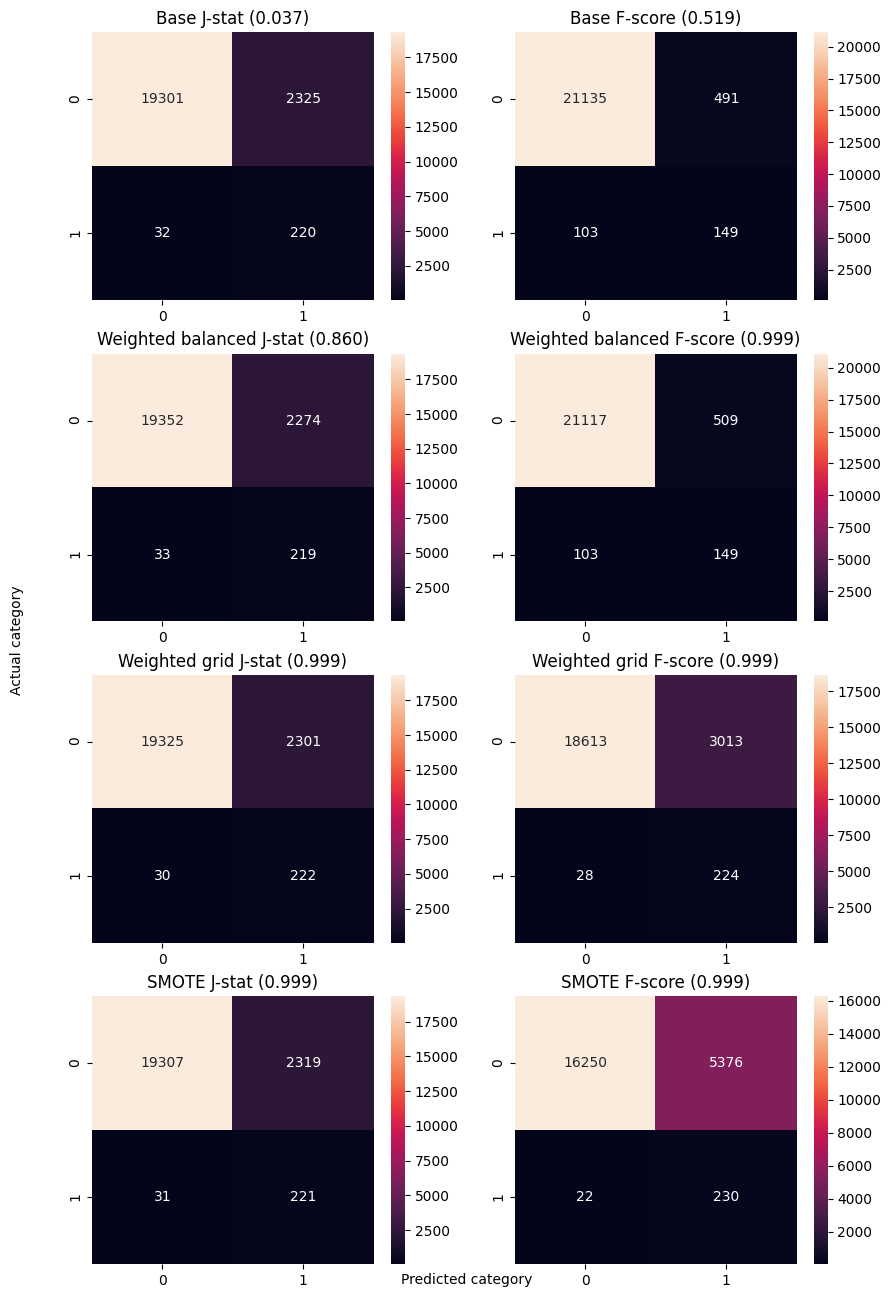

In [ ]:
#Confusion matrices comparison
cm = [cm_base_J,cm_base_fbeta, cm_w_J, cm_w_fbeta, cm_w_J1, cm_w_fbeta1, cm_sm_J, cm_sm_fbeta]
titles = ['Base J-stat (0.037)','Base F-score (0.519)','Weighted balanced J-stat (0.860)',
          'Weighted balanced F-score (0.999)','Weighted grid J-stat (0.999)', 'Weighted grid F-score (0.999)', 
          'SMOTE J-stat (0.999)', 'SMOTE F-score (0.999)']
fig, axs = plt.subplots(4,2, figsize=(10, 16))
axs = axs.ravel()

for i in np.arange(0,8):
  sns.heatmap(cm[i], annot=True, fmt="d", ax=axs[i])
  axs[i].set_title('{}'.format(titles[i]))
  #axs[i].set_ylabel('Actual label')
  #axs[i].set_xlabel('Predicted label')

fig.text(0.5, 0.1, 'Predicted category', ha='center', va='center')
fig.text(0.05, 0.5, 'Actual category', ha='center', va='center', rotation='vertical')
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.9.png',dpi=300)


In [ ]:
#Function to determine optimal thresholds (Youden's J) and measures

def measures(Y_test, Y_predict, stat_j = True):
  #Calculate the optimal threshold in a grid based on Youden's J- stat
  # calculate roc curves
  fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
  roc_auc = auc(fpr, tpr)
  if stat_j == True:
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = round(thresholds[ix],4)
    #Confusion matrix
    #Find prediction to the dataframe applyin threshold
    pred = (Y_predict >= thresholds[ix]).astype(int)
    # Print confusion Matrix
    cm = confusion_matrix(Y_test, pred) #conf. matrix thres. Youden J weighted model
  else:
    threshold = np.arange(0, 1, 0.001)
    scores = [fbeta_score(Y_test, to_labels(Y_predict, t), beta=2.0) for t in threshold]
    # get best threshold
    ix = np.argmax(scores)
    best_thresh = round(threshold[ix],3)
    pred = (Y_predict >= threshold[ix]).astype(int)
    cm = confusion_matrix(Y_test, pred)
  TP = cm[1,1]
  TN = cm[0,0]
  FP = cm[0,1]
  FN = cm[1,0]
  measures = pd.DataFrame()
  measures['PPV'] = [TP / (TP + FP)]
  measures['Acc'] = [(TN + TP) / np.sum(cm)]
  measures['Acc_Bal'] = [(TP/(2*(TP+FN)))+(TN/(2*(TN+FP)))]
  measures['Sensitivity'] = [TP / (TP + FN)]
  measures['Specificity'] = [TN / (TN + FP)]
  measures['MCC'] = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
  measures['AUC'] = [roc_auc]
  measures['Threshold'] = [best_thresh]

  return measures

In [ ]:
models = (Y_predict,Y_predict0,Y_predict1,Y_predict_sm)
meas_J = pd.DataFrame() #measures based on J-stat
for m in models:
  me = measures(Y_test,m)
  meas_J = meas_J.append(me)

meas_F = pd.DataFrame() #measures based on F-score
for m in models:
  me = measures(Y_test,m,False)
  meas_F = meas_F.append(me)

In [ ]:
#Summary measures different refinements of the model (threshold by J-statistic)
meas_J = meas_J.transpose()
meas_J.reset_index(inplace=True)
meas_J.columns = ['Measure','Original','Balanced','Weighted on Grid','SMOTE']
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)
meas_J.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.10.tex',index=False)
meas_J

,Measure,Original,Balanced,Weighted on Grid,SMOTE
0,PPV,0.087,0.088,0.089,0.087
1,Acc,0.893,0.894,0.895,0.893
2,Acc_Bal,0.883,0.884,0.888,0.885
3,Sensitivity,0.873,0.873,0.881,0.877
4,Specificity,0.893,0.895,0.895,0.893
5,MCC,0.255,0.258,0.260,0.256
6,AUC,0.926,0.927,0.927,0.927
7,Threshold,0.037,0.860,1.000,1


In [ ]:
##Summary measures different refinements of the model (by J-statistic)
meas_F = meas_F.transpose()
meas_F.reset_index(inplace=True)
meas_F.columns = ['Measure','Original','Balanced','Weighted in Grid','SMOTE']
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)
meas_F.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.11.tex',index=False)
meas_F

,Measure,Original,Balanced,Weighted in Grid,SMOTE
0,PPV,0.233,0.226,0.069,0.041
1,Acc,0.973,0.972,0.861,0.753
2,Acc_Bal,0.784,0.784,0.875,0.832
3,Sensitivity,0.591,0.591,0.889,0.913
4,Specificity,0.977,0.976,0.861,0.751
5,MCC,0.360,0.355,0.225,0.162
6,AUC,0.926,0.927,0.927,0.927
7,Threshold,0.519,0.999,0.999,0.999


In [ ]:
#ROC curves for base and weighted data

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)
  J = tp - fp
  ix = np.argmax(J)
  plt.figure(figsize=(10, 12))
  plt.scatter(100*fp[ix], 100*tp[ix], marker='o', color='black', label='Best')
  plt.plot([0,100], [0,100], linestyle='--', label='No Skill')
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives (%)')
  plt.ylabel('True positives (%)')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(linestyle='dotted')
  ax = plt.gca()
  ax.set_aspect('equal')
  

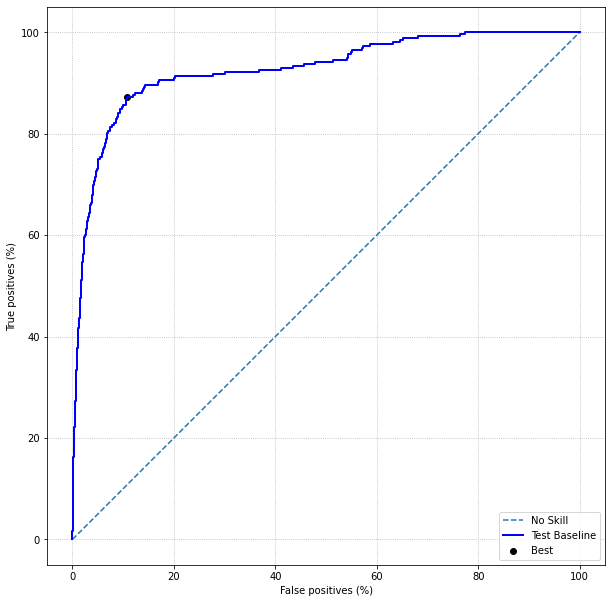

In [ ]:
plot_roc("Test Baseline", Y_test, Y_predict, color='blue')
plt.legend(loc='lower right')
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.10.png',dpi=300)

In [ ]:
#Selection model Murtaugh 
https://www.nature.com/articles/s41598-017-04841-z.pdf
https://www.researchgate.net/publication/262145087_Model_selection_for_ecologists_The_worldviews_of_AIC_and_BIC

#Logistic reg
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

#AIC BIC
https://machinelearningmastery.com/probabilistic-model-selection-measures/

In [ ]:
#Given the previous results, maybe recall-precision balance is a better option
#recall is able to find relevant cases in our data set
#precision is able to identify only relevant data points
#use f2_score
#see
https://machinelearningmastery.com/what-is-imbalanced-classification/
https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/
https://machinelearningmastery.com/fbeta-measure-for-machine-learning/
https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [ ]:
#Export results
https://stackoverflow.com/questions/42908311/statsmodel-summary-col-latex-format-error

#optimal roc
https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python



### Completeness

In [ ]:
#Estimation of the other 6 models
Y_predict1 = np.array(result_1.predict(X_test[['const','IMB_RATIO']]))
Y_predict2 = np.array(result_2.predict(X_test[['const','NUM_TICKS']]))
Y_predict3 = np.array(result_3.predict(X_test[['const','SPREAD']]))
Y_predict4 = np.array(result_4.predict(X_test[['const','NUM_TICKS','SPREAD']]))
Y_predict5 = np.array(result_5.predict(X_test[['const','IMB_RATIO','NUM_TICKS']]))
Y_predict6 = np.array(result_6.predict(X_test[['const','IMB_RATIO','SPREAD']]))


In [ ]:
models = (Y_predict1,Y_predict2,Y_predict3,Y_predict4,Y_predict5,Y_predict6)
meas = pd.DataFrame()
for m in models:
  me = measures(Y_test,m)
  meas = meas.append(me)
  

In [ ]:
#out of sample classification measures of the restricted models
meas = meas.transpose()
meas.reset_index(inplace=True)
meas.columns = ['Measure','(1)','(2)','(3)','(4)','(5)','(6)']
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)
meas.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.12.tex',index=False)
meas

,Measure,(1),(2),(3),(4),(5),(6)
0,PPV,0.013,0.070,0.072,0.085,0.060,0.075
1,Acc,0.978,0.874,0.869,0.889,0.852,0.878
2,Acc_Bal,0.501,0.842,0.869,0.883,0.833,0.866
3,Sensitivity,0.012,0.810,0.869,0.877,0.813,0.853
4,Specificity,0.989,0.875,0.869,0.889,0.853,0.878
5,MCC,0.001,0.215,0.227,0.252,0.196,0.232
6,AUC,0.319,0.901,0.876,0.924,0.900,0.885
7,Threshold,0.011,0.012,0.020,0.038,0.009,0.020


In [ ]:
######################################## 
# Beyond usual logit model
########################################

#decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
#clf = clf.fit(X_train, Y_train)
#Y_pred_tree = clf.predict_proba(X_test)[:, 1]

#gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier(random_state=42)
#grad.fit(X_train, Y_train)
#Y_pred_grad = grad.predict_proba(X_test)[:, 1]

#Random Forest
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=2, random_state=42)
#forest.fit(X_train, Y_train)
#Y_pred_forest = forest.predict(X_test)

models = dict({'Tree':clf, 'Gradient': grad, 'Forest': forest})

In [ ]:
losses_cv, auc_cv, names, mean_auc, mean_loss = list(), list(), list(), list(), list()
for name, model in models.items():
  score_cv = cross_val_score(model, X_train, Y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
  #loss_cv = cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_log_loss', n_jobs=-1)
  names.append(name)
  #losses_cv.append(loss_cv)
  auc_cv.append(score_cv)
  mean_auc.append(np.mean(score_cv))
  #mean_loss.append(np.mean(loss_cv))

In [ ]:
#Save results as pickle 
output = open('/content/drive/My Drive/Tesis Konstanz/Clean data/classifiers_auc_cv.pkl', 'wb')
pickle.dump(auc_cv, output)
output.close()

In [ ]:
pkl_file = open('/content/drive/My Drive/Tesis Konstanz/Clean data/classifiers_auc_cv.pkl', 'rb')
class_auc_cv = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('/content/drive/My Drive/Tesis Konstanz/Clean data/auc_cv.pkl', 'rb')
auc_cv = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
pkl_file = open('/content/drive/My Drive/Tesis Konstanz/Clean data/classifiers_auc_cv.pkl', 'rb')
class_auc_cv = pickle.load(pkl_file)
pkl_file.close()

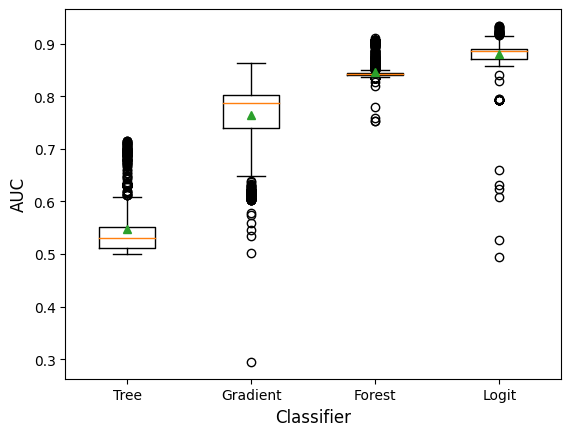

In [ ]:
class_auc_cv.append(np.array(auc_cv)[6])
names.append('Logit')
plt.boxplot(class_auc_cv, labels=names, showmeans=True)
plt.xlabel("Classifier", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.11.png', dpi=300)
plt.show()

In [ ]:
def compare_classifiers(models, X_train,Y_train,X_test,Y_test):
  Y_pred, best_th, cms, aucs, auc_in = list(),list(),list(),list(),list()
  for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_predict = model.predict_proba(X_test)[:, 1]
    Y_pred.append(Y_predict)
    Y_predict_in = model.predict_proba(X_train)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    fpr_in, tpr_in, _ = roc_curve(Y_train, Y_predict_in)
    roc_auc_in = auc(fpr_in, tpr_in)
    auc_in.append(roc_auc_in)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = round(thresholds[ix],4)
    best_th.append(best_thresh)
    pred = (Y_predict >= thresholds[ix]).astype(int)
    cm = confusion_matrix(Y_test, pred)
    cms.append(cm)
  return Y_pred, best_th, cms, aucs, auc_in


In [ ]:
Y_pred, best_th, cms, aucs, auc_in = compare_classifiers(models, X_train,Y_train,X_test,Y_test)
_,best_th_smote, cms_smote, aucs_smote, auc_in_smote = compare_classifiers(models, X_smote, Y_smote, X_test, Y_test)


In [ ]:
meas_class = pd.DataFrame()
for m in Y_pred:
  me = measures(Y_test,m)
  meas_class = meas_class.append(me)
meas_class = meas_class.transpose()
meas_class.reset_index(inplace=True)
meas_class.columns = ['Measure','Decision tree','Gradient boosting','Random forest']
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)
meas_class.to_latex('/content/drive/My Drive/Tesis Konstanz/Clean data/tables/table4.13.tex',index=False)
meas_class


,Measure,Decision tree,Gradient boosting,Random forest
0,PPV,0.079,0.069,0.064
1,Acc,0.950,0.860,0.851
2,Acc_Bal,0.635,0.872,0.866
3,Sensitivity,0.313,0.885,0.881
4,Specificity,0.957,0.860,0.850
5,MCC,0.138,0.223,0.214
6,AUC,0.635,0.924,0.912
7,Threshold,1,0.025,0.053


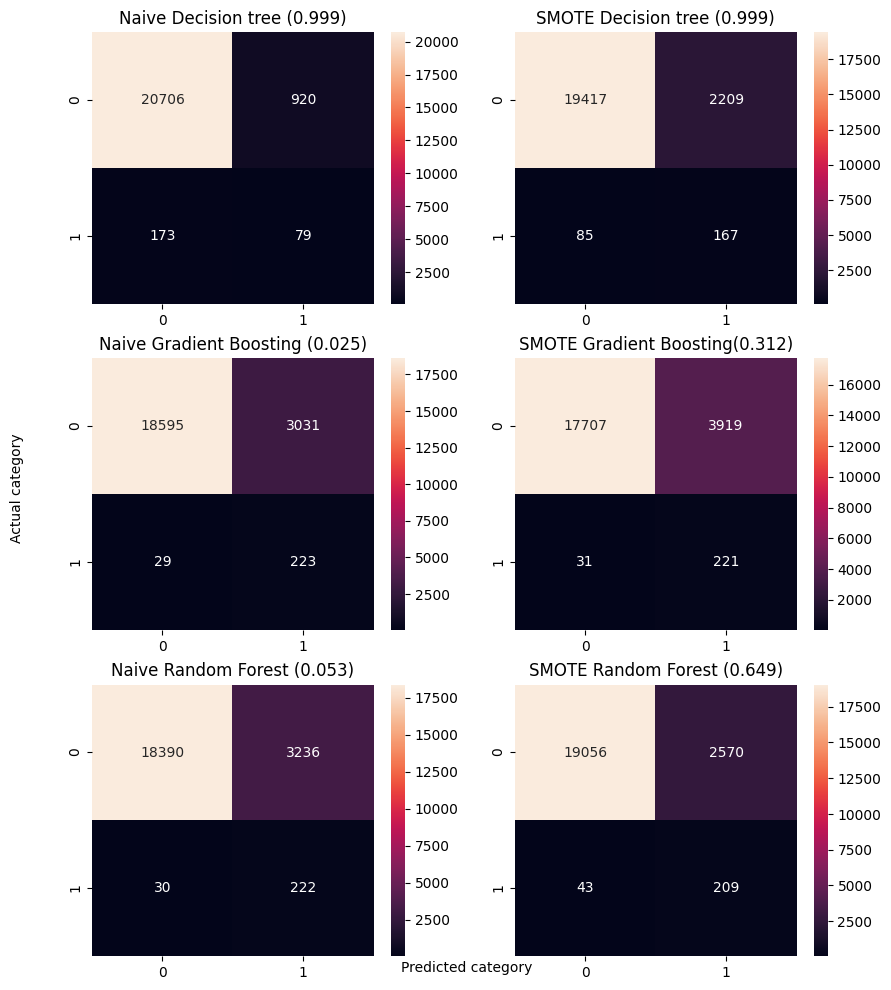

In [ ]:
#Confusion matrices comparison
cm = [cms[0],cms_smote[0],cms[1],cms_smote[1],cms[2],cms_smote[2]]
titles = ['Naive Decision tree (0.999)', 'SMOTE Decision tree (0.999)',
          'Naive Gradient Boosting (0.025)', 'SMOTE Gradient Boosting(0.312)',
          'Naive Random Forest (0.053)', 'SMOTE Random Forest (0.649)']
fig, axs = plt.subplots(3,2, figsize=(10, 12))
axs = axs.ravel()

for i in np.arange(0,6):
  sns.heatmap(cm[i], annot=True, fmt="d", ax=axs[i])
  axs[i].set_title('{}'.format(titles[i]))
  #axs[i].set_ylabel('Actual label')
  #axs[i].set_xlabel('Predicted label')

fig.text(0.5, 0.1, 'Predicted category', ha='center', va='center')
fig.text(0.05, 0.5, 'Actual category', ha='center', va='center', rotation='vertical')
plt.savefig('/content/drive/My Drive/Tesis Konstanz/Clean data/graphs/fig4.12.png',dpi=300)

In [ ]:
#Cost sensitive logit

#To do a cost analysis first we have to take the costs
#I estimate the costs by using the "effective spread" but trade data is necessary

def resample_trade(clean_data,interval='s'): 
  clean_data = clean_data.set_index(pd.DatetimeIndex(clean_data['TIME_M']))
  clean_data= clean_data.resample(interval).agg({'PRICE':'mean', 'SIZE':'mean'})                                                
                                                
  clean_data = clean_data.dropna()
  UPDATE_PRICE = clean_data['PRICE'] - clean_data['PRICE'].shift(1)
  return clean_data[(UPDATE_PRICE!=0)].copy()

s_p_trade = pd.read_csv('/content/drive/My Drive/Tesis Konstanz/Clean data/data/s&p_cleaned_trade.csv')
s_p_sec_trade = resample_trade(s_p_trade)
s_p_quote_trade = s_p_sec.join(s_p_sec_trade, how='inner')
s_p_quote_trade = s_p_quote_trade.join(Y_train, how='inner')

dow_trade = pd.read_csv('/content/drive/My Drive/Tesis Konstanz/Clean data/data/djia_cleaned_trade.csv')
dow_sec_trade = resample_trade(dow_trade)
dow_quote_trade = dow_sec.join(dow_sec_trade, how='inner')


#We need a matrix of costs
#true positive/false negative cost = cost transaction *(1 + average cost fc)
#false positive cost = cost transaction
#true negative = no cost 

#transaction costs are equal to the "effective spread"
cost_mat_train = np.zeros((len(s_p_quote_trade),4)) #first the cost matrix full of zeros
s_p_quote_trade['EF_SPREAD'] = 2*(s_p_quote_trade.PRICE - s_p_quote_trade.MID_QUOTE)
cost_fc = -fc_stats_sp.LOSS_PEAK.mean()

#false positive cost
cost_mat_train[:,0] = s_p_quote_trade.EF_SPREAD*s_p_quote_trade.SIZE
#false negative cost
cost_mat_train[:,1] = s_p_quote_trade.PRICE*(cost_fc/100)*s_p_quote_trade.SIZE + s_p_quote_trade.EF_SPREAD*s_p_quote_trade.SIZE
#true positive cost
cost_mat_train[:,2] = s_p_quote_trade.EF_SPREAD*(1 + cost_fc/100)
#true negative cost
cost_mat_train[:,3] = s_p_quote_trade.EF_SPREAD

dow_quote_trade['EF_SPREAD'] = 2*100*(dow_quote_trade.PRICE - dow_quote_trade.MID_QUOTE)/dow_quote_trade.MID_QUOTE
#fc_stats_dj.LOSS_PEAK.mean()

In [ ]:
s_p_quote_trade['IMB_RATIO'] = np.log10(s_p_quote_trade.ASKSIZ/s_p_quote_trade.BIDSIZ)
Y_train_cost = s_p_quote_trade['PROB'] 
X_train_cost = s_p_quote_trade[['SPREAD','NUM_TICKS','IMB_RATIO']].copy()
X_train_cost[X_train_cost.columns] = scaler.fit_transform(X_train_cost)
X_train_cost = sm.add_constant(X_train_cost)


# Appendix